# **Nested Cross-Validation for Model Selection and Tuning**

**Challenge:** Implement nested cross-validation to compare multiple models and tune their hyperparameters simultaneously.

**Goal:** Prevent biased performance estimates when selecting models using tuning.

**Tools:**
  * GridSearchCV or RandomizedSearchCV
  * cross_val_score
  * Different models like RandomForestClassifier, SVC, KNeighborsClassifier

**What to Observe:**
  * Compare outer-loop test scores of each algorithm
  * Trade-offs between model complexity and performance stability


In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Load the wine dataset
X, y = load_wine(return_X_y=True)
print("Loaded wine dataset with", X.shape[0], "samples and", X.shape[1], "features")

# Define models and their hyperparameter grids
# Using RandomForest, SVC, and KNN
models = {
    'RandomForest': RandomForestClassifier(random_state=42),  # Added random_state for reproducibility
    'SVC': SVC(random_state=42),
    'KNeighbors': KNeighborsClassifier()
}

# Parameter grids
param_grids = {
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [3, 6]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNeighbors': {'n_neighbors': [3, 5, 7]}
}

# Nested cross-validation setup
outer_cv = 5  # 5 folds for outer loop
inner_cv = 3  # 3 folds for inner loop

# Store results
results = {}

for model_name, model in models.items():
    print(f"\nRunning nested CV for {model_name}...")
    # Inner loop: tune hyperparameters
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=inner_cv,
        scoring='accuracy'
    )

    # Outer loop: evaluate tuned model
    scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring='accuracy')

    # Save results
    results[model_name] = {
        'mean_score': np.mean(scores),
        'std_score': np.std(scores),
        'scores': scores
    }

    # Print observations
    print(f"Outer-loop scores: {scores.round(3)}")
    print(f"Mean accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Compare models
print("\nModel Comparison:")
for model_name, result in results.items():
    print(f"{model_name}: Mean Accuracy = {result['mean_score']:.3f}, "
          f"Std = {result['std_score']:.3f}")

# Find best model
best_model = max(results, key=lambda x: results[x]['mean_score'])
print(f"\nBest Model: {best_model} with mean accuracy "
      f"{results[best_model]['mean_score']:.3f}")

# SVC might take longer due to Wine's 13 features
# RandomForest seems to have stable std, good for generalization maybe?

Loaded wine dataset with 178 samples and 13 features

Running nested CV for RandomForest...
Outer-loop scores: [0.917 0.944 0.972 1.    1.   ]
Mean accuracy: 0.967 ± 0.032

Running nested CV for SVC...
Outer-loop scores: [0.917 0.944 0.944 1.    1.   ]
Mean accuracy: 0.961 ± 0.033

Running nested CV for KNeighbors...
Outer-loop scores: [0.639 0.611 0.639 0.743 0.771]
Mean accuracy: 0.681 ± 0.064

Model Comparison:
RandomForest: Mean Accuracy = 0.967, Std = 0.032
SVC: Mean Accuracy = 0.961, Std = 0.033
KNeighbors: Mean Accuracy = 0.681, Std = 0.064

Best Model: RandomForest with mean accuracy 0.967


# **Learning Curves and Validation Curves Analysis**

**Challenge:** Plot learning and validation curves to diagnose whether a model suffers from high bias or variance.

**Goal:** Use visualization to tune training size or hyperparameters like regularization strength.

**Tools:**
  * learning_curve, validation_curve from sklearn.model_selection
  * Models like Ridge, LogisticRegression, SVC
  * matplotlib for visualization

**What to Observe:**
  * Curve convergence (bias/variance trade-off)
  * Optimal training data size
  * Overfitting/underfitting diagnostics


Loaded wine dataset with 178 samples and 13 features



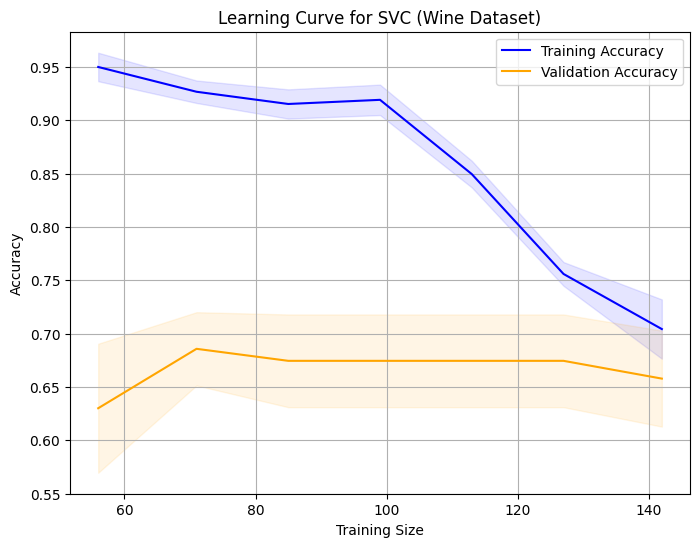

Learning Curve: Checking for convergence or gaps



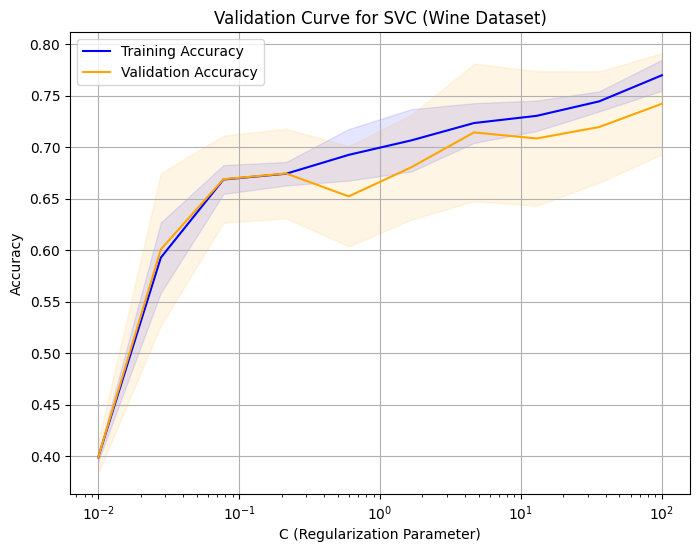

Validation Curve: Finding optimal C for best performance


In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Load wine dataset
X, y = load_wine(return_X_y=True)
print("Loaded wine dataset with", X.shape[0], "samples and", X.shape[1], "features")
print()

# Use SVC model
model = SVC(kernel='rbf', random_state=42)  # Fixed kernel and random_state

# Plot Learning Curve
# Checking how accuracy changes with training size
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X, y,
    cv=5,  # 5-fold CV as in lecture
    train_sizes=np.linspace(0.1, 1.0, 10),  # Varying training sizes
    scoring='accuracy'
)

# Compute mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for SVC (Wine Dataset)')
plt.legend()
plt.grid(True)
plt.show()

# Wide gap between curves suggests overfitting
# If both curves are low, might be underfitting
print("Learning Curve: Checking for convergence or gaps")
print()

# Plot Validation Curve
# Testing different C values to tune regularization
param_range = np.logspace(-2, 2, 10)  # C from 0.01 to 100
train_scores, val_scores = validation_curve(
    model,
    X, y,
    param_name='C',
    param_range=param_range,
    cv=5,  # 5-fold CV
    scoring='accuracy'
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.semilogx(param_range, train_mean, label='Training Accuracy', color='blue')
plt.semilogx(param_range, val_mean, label='Validation Accuracy', color='orange')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for SVC (Wine Dataset)')
plt.legend()
plt.grid(True)
plt.show()

# Looking for C where validation accuracy is highest
# High C with dropping validation accuracy might mean overfitting
print("Validation Curve: Finding optimal C for best performance")

# Wine dataset has more features, so SVC might need careful tuning
# Learning curve might show if we need more data